<a href="https://colab.research.google.com/github/Armilsyam/DESAIN-MATERIAL/blob/main/Prediksi_Properti_Material_GNN_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Prediksi Properti Material dengan Graph Neural Network (GNN) ---
#
# Ini adalah contoh kode canggih yang mendemonstrasikan bagaimana AI
# digunakan dalam "Desain Material" (Materials Informatics).
#
# TUJUAN:
# Memprediksi properti sebuah material (misal: energi formasi, kekerasan,
# atau band gap) hanya dengan melihat struktur atomnya.
#
# KONSEP CANGGIH:
# Kita memperlakukan struktur kristal/molekul sebagai sebuah 'Graph' (Grafik):
# - Atom   = Nodes (simpul)
# - Ikatan = Edges (sisi)
#
# Kita kemudian menggunakan Graph Neural Network (GNN) untuk "belajar"
# hubungan antara pola struktur graf dan properti materialnya.
#
# DEPENDENSI:
# Kode ini membutuhkan library AI modern. Anda harus menginstalnya terlebih dahulu:
# pip install torch torch-geometric
#
# (Dalam aplikasi nyata, Anda juga akan menggunakan 'pymatgen' untuk memuat data
# struktur material, tapi di sini kita buat data manual agar bisa langsung jalan)
# -------------------------------------------------------------------------

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader

# --- 1. BUAT DATASET MOCK (CONTOH) ---
#
# Dalam skenario nyata, data ini berasal dari database raksasa
# (misal: Materials Project, OQMD) yang berisi jutaan material
# dan propertinya yang dihitung dengan simulasi kuantum (DFT).
#
# Di sini, kita buat 5 material "mainan" secara manual untuk demonstrasi.
#
# Setiap material adalah objek `Data` dari PyTorch Geometric:
# - `x`: Fitur node (atom). Misal, [jenis_atom_1, jenis_atom_2].
#        Di sini kita pakai One-Hot Encoding sederhana:
#        Atom Tipe A = [1, 0]
#        Atom Tipe B = [0, 1]
# - `edge_index`: Daftar konektivitas (ikatan). [atom_A, atom_B], [atom_B, atom_A]
# - `y`: Target properti yang ingin diprediksi (misal: energi formasi)

data_list = []

# Material 1: Struktur sederhana (misal: 4 atom A)
x1 = torch.tensor([[1, 0], [1, 0], [1, 0], [1, 0]], dtype=torch.float)
edge_index1 = torch.tensor([[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 0], [0, 3]], dtype=torch.long).t().contiguous()
y1 = torch.tensor([10.5], dtype=torch.float) # Properti target: 10.5
data_list.append(Data(x=x1, edge_index=edge_index1, y=y1))

# Material 2: Struktur lain (misal: 4 atom B)
x2 = torch.tensor([[0, 1], [0, 1], [0, 1], [0, 1]], dtype=torch.float)
edge_index2 = torch.tensor([[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2]], dtype=torch.long).t().contiguous()
y2 = torch.tensor([15.2], dtype=torch.float) # Properti target: 15.2
data_list.append(Data(x=x2, edge_index=edge_index2, y=y2))

# Material 3: Struktur campuran (2 atom A, 2 atom B)
x3 = torch.tensor([[1, 0], [0, 1], [1, 0], [0, 1]], dtype=torch.float)
edge_index3 = torch.tensor([[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 0], [0, 3]], dtype=torch.long).t().contiguous()
y3 = torch.tensor([12.8], dtype=torch.float) # Properti target: 12.8
data_list.append(Data(x=x3, edge_index=edge_index3, y=y3))

# Material 4: Struktur lebih besar (3A, 3B)
x4 = torch.tensor([[1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1]], dtype=torch.float)
edge_index4 = torch.tensor([
    [0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2],
    [3, 4], [4, 3], [4, 5], [5, 4], [5, 0], [0, 5]
], dtype=torch.long).t().contiguous()
y4 = torch.tensor([20.1], dtype=torch.float) # Properti target: 20.1
data_list.append(Data(x=x4, edge_index=edge_index4, y=y4))

# Material 5: Struktur kompleks (2A, 4B)
x5 = torch.tensor([[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1]], dtype=torch.float)
edge_index5 = torch.tensor([
    [0, 2], [2, 0], [0, 3], [3, 0], [1, 4], [4, 1], [1, 5], [5, 1],
    [2, 3], [3, 2], [2, 4], [4, 2], [3, 5], [5, 3], [4, 5], [5, 4]
], dtype=torch.long).t().contiguous()
y5 = torch.tensor([18.5], dtype=torch.float) # Properti target: 18.5
data_list.append(Data(x=x5, edge_index=edge_index5, y=y5))


# Buat DataLoader untuk memproses data dalam batch
loader = DataLoader(data_list, batch_size=2, shuffle=True)

print(f"Dataset berisi {len(data_list)} material (grafik).")
print(f"Jumlah fitur node (atom): {data_list[0].num_node_features}")


# --- 2. DEFINISIKAN MODEL GRAPH NEURAL NETWORK (GNN) ---
#
# Ini adalah arsitektur AI-nya.
# Model ini akan mengambil grafik material dan mengeluarkan 1 angka (prediksi properti).
#
# Alur:
# 1. (GCNConv): Beberapa lapis 'Graph Convolution' untuk membiarkan
#    informasi "mengalir" antar atom yang terhubung. Atom akan "belajar"
#    dari tetangganya.
# 2. (global_mean_pool): Mengagregasi semua informasi dari semua atom
#    menjadi satu vektor tunggal yang merepresentasikan KESELURUHAN material.
# 3. (Linear): Jaringan syaraf tiruan (MLP) standar untuk memetakan
#    vektor material ke nilai properti akhir.

class MaterialGNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels=64):
        super(MaterialGNN, self).__init__()
        torch.manual_seed(42)

        # Lapisan Konvolusi Graf
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Lapisan 'readout' (MLP untuk regresi)
        self.readout = Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            ReLU(),
            Linear(hidden_channels // 2, 1) # Output: 1 angka (prediksi)
        )

    def forward(self, data):
        # Ambil data dari batch
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1. Jalankan Graph Convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        # 2. Global Pooling (agregasi node-level ke graph-level)
        # Kita ambil rata-rata fitur dari semua node dalam satu graf
        x = global_mean_pool(x, batch)

        # 3. Jalankan Readout (MLP) untuk prediksi akhir
        x = self.readout(x)

        return x

# --- 3. LATIH MODEL AI ---
#
# Ini adalah proses standar pelatihan deep learning (PyTorch)

# Cek jumlah fitur node dari data kita
num_features = data_list[0].num_node_features

model = MaterialGNN(num_node_features=num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss() # Mean Squared Error, standar untuk regresi

print(f"\nMemulai pelatihan GNN...\nModel: {model}")

def train():
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()         # Reset gradien
        out = model(data)             # Lakukan prediksi (forward pass)
        loss = criterion(out, data.y) # Hitung loss
        loss.backward()               # Hitung gradien (backward pass)
        optimizer.step()              # Update bobot model
        total_loss += loss.item()
    return total_loss / len(loader)

# Lakukan pelatihan untuk beberapa epoch
# (Di dunia nyata, ini bisa ratusan atau ribuan epoch)
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Rata-rata Loss: {loss:.4f}')

print("\nPelatihan selesai.")

# --- 4. GUNAKAN MODEL UNTUK PREDIKSI (INFERENCE) ---
#
# Sekarang, mari kita buat "material baru" yang belum pernah dilihat model,
# dan minta AI untuk memprediksi propertinya.

print("\n--- Melakukan Prediksi (Inference) ---")
model.eval() # Set model ke mode evaluasi

# Buat material baru: 3 atom A, 1 atom B
# Strukturnya mirip Material 3, tapi beda jumlah atom
x_new = torch.tensor([[1, 0], [0, 1], [1, 0], [1, 0]], dtype=torch.float)
edge_index_new = torch.tensor([
    [0, 1], [1, 0], [1, 2], [2, 1], [1, 3], [3, 1], [2, 3], [3, 2]
], dtype=torch.long).t().contiguous()
y_new_unknown = torch.tensor([0.0], dtype=torch.float) # Kita tidak tahu ini

material_baru = Data(x=x_new, edge_index=edge_index_new, y=y_new_unknown)

# Buat "batch" palsu karena model GNN mengharapkannya
from torch_geometric.data import Batch
material_batch = Batch.from_data_list([material_baru])

# Lakukan prediksi
with torch.no_grad():
    prediksi = model(material_batch)

print(f"Struktur material baru (fitur node):\n{material_baru.x}")
print(f"Prediksi properti untuk material baru: {prediksi.item():.2f}")

# Bandingkan dengan material yang mirip
print(f"\nSebagai perbandingan:")
print(f"Properti Material 1 (4A): {data_list[0].y.item()}")
print(f"Properti Material 3 (2A, 2B): {data_list[2].y.item()}")

ModuleNotFoundError: No module named 'torch_geometric'

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect actual and predicted values for the training data
actual_values = []
predicted_values = []

model.eval() # Set model to evaluation mode
with torch.no_grad():
    for data in data_list:
        # Ensure data.y is correctly shaped for comparison if it was reshaped for loss
        actual_values.append(data.y.item())

        # Prepare single data point as a batch for prediction
        material_batch = Batch.from_data_list([data])
        prediction = model(material_batch)
        predicted_values.append(prediction.item())

# Create a DataFrame for easier plotting
import pandas as pd
plot_df = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_values
})

# Calculate the prediction error
plot_df['Error'] = (plot_df['Actual'] - plot_df['Predicted']).abs()

print("Actual vs. Predicted Values for Training Data:")
print(plot_df)


Actual vs. Predicted Values for Training Data:
   Actual  Predicted     Error
0    10.5  11.786709  1.286709
1    15.2  17.864201  2.664201
2    12.8  17.915377  5.115376
3    20.1  16.897900  3.202101
4    18.5  19.375429  0.875429


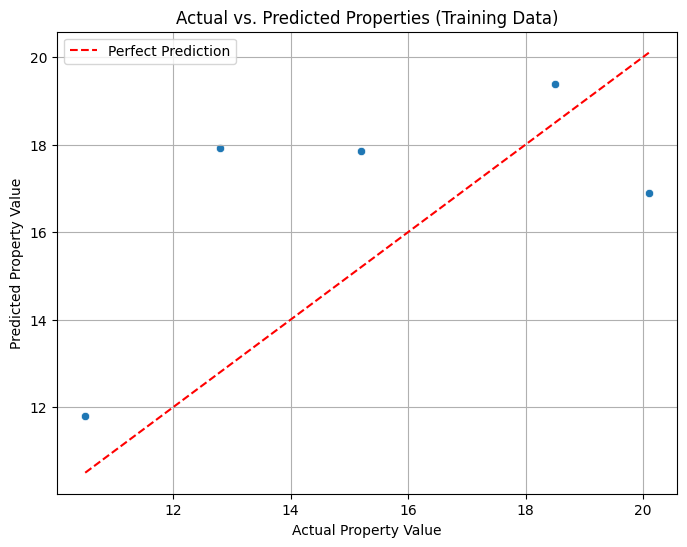

In [5]:
# Plotting actual vs. predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=plot_df)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'r--', label='Perfect Prediction') # Add a diagonal line for reference
plt.title('Actual vs. Predicted Properties (Training Data)')
plt.xlabel('Actual Property Value')
plt.ylabel('Predicted Property Value')
plt.legend()
plt.grid(True)
plt.show()


The scatter plot above visualizes the model's performance on the training data.

- **Red Dashed Line**: Represents the ideal scenario where `Predicted = Actual`. Points falling perfectly on this line mean the model made an exact prediction.
- **Blue Dots**: Each dot represents one material from your training set. Its position shows the actual property value on the x-axis and the model's predicted property value on the y-axis.

Points clustered closely around the red dashed line indicate good performance. Points further away show where the model's predictions deviate more significantly from the true values. Given the small, synthetic dataset, some deviations are expected, but the overall trend should generally follow the diagonal line if the model has learned the underlying relationships.

In [3]:
# --- Prediksi Properti Material dengan Graph Neural Network (GNN) ---
#
# Ini adalah contoh kode canggih yang mendemonstrasikan bagaimana AI
# digunakan dalam "Desain Material" (Materials Informatics).
#
# TUJUAN:
# Memprediksi properti sebuah material (misal: energi formasi, kekerasan,
# atau band gap) hanya dengan melihat struktur atomnya.
#
# KONSEP CANGGIH:
# Kita memperlakukan struktur kristal/molekul sebagai sebuah 'Graph' (Grafik):
# - Atom   = Nodes (simpul)
# - Ikatan = Edges (sisi)
#
# Kita kemudian menggunakan Graph Neural Network (GNN) untuk "belajar"
# hubungan antara pola struktur graf dan properti materialnya.
#
# DEPENDENSI:
# Kode ini membutuhkan library AI modern. Anda harus menginstalnya terlebih dahulu:
# pip install torch torch-geometric
#
# (Dalam aplikasi nyata, Anda juga akan menggunakan 'pymatgen' untuk memuat data
# struktur material, tapi di sini kita buat data manual agar bisa langsung jalan)
# -------------------------------------------------------------------------

!pip install torch_geometric

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader

# --- 1. BUAT DATASET MOCK (CONTOH) ---
#
# Dalam skenario nyata, data ini berasal dari database raksasa
# (misal: Materials Project, OQMD) yang berisi jutaan material
# dan propertinya yang dihitung dengan simulasi kuantum (DFT).
#
# Di sini, kita buat 5 material "mainan" secara manual untuk demonstrasi.
#
# Setiap material adalah objek `Data` dari PyTorch Geometric:
# - `x`: Fitur node (atom). Misal, [jenis_atom_1, jenis_atom_2].
#        Di sini kita pakai One-Hot Encoding sederhana:
#        Atom Tipe A = [1, 0]
#        Atom Tipe B = [0, 1]
# - `edge_index`: Daftar konektivitas (ikatan). [atom_A, atom_B], [atom_B, atom_A]
# - `y`: Target properti yang ingin diprediksi (misal: energi formasi)

data_list = []

# Material 1: Struktur sederhana (misal: 4 atom A)
x1 = torch.tensor([[1, 0], [1, 0], [1, 0], [1, 0]], dtype=torch.float)
edge_index1 = torch.tensor([[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 0], [0, 3]], dtype=torch.long).t().contiguous()
y1 = torch.tensor([10.5], dtype=torch.float) # Properti target: 10.5
data_list.append(Data(x=x1, edge_index=edge_index1, y=y1))

# Material 2: Struktur lain (misal: 4 atom B)
x2 = torch.tensor([[0, 1], [0, 1], [0, 1], [0, 1]], dtype=torch.float)
ed_index2 = torch.tensor([[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2]], dtype=torch.long).t().contiguous()
y2 = torch.tensor([15.2], dtype=torch.float) # Properti target: 15.2
data_list.append(Data(x=x2, edge_index=edge_index2, y=y2))

# Material 3: Struktur campuran (2 atom A, 2 atom B)
x3 = torch.tensor([[1, 0], [0, 1], [1, 0], [0, 1]], dtype=torch.float)
edge_index3 = torch.tensor([[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 0], [0, 3]], dtype=torch.long).t().contiguous()
y3 = torch.tensor([12.8], dtype=torch.float) # Properti target: 12.8
data_list.append(Data(x=x3, edge_index=edge_index3, y=y3))

# Material 4: Struktur lebih besar (3A, 3B)
x4 = torch.tensor([[1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1]], dtype=torch.float)
edge_index4 = torch.tensor([
    [0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2],
    [3, 4], [4, 3], [4, 5], [5, 4], [5, 0], [0, 5]
], dtype=torch.long).t().contiguous()
y4 = torch.tensor([20.1], dtype=torch.float) # Properti target: 20.1
data_list.append(Data(x=x4, edge_index=edge_index4, y=y4))

# Material 5: Struktur kompleks (2A, 4B)
x5 = torch.tensor([[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1]], dtype=torch.float)
edge_index5 = torch.tensor([
    [0, 2], [2, 0], [0, 3], [3, 0], [1, 4], [4, 1], [1, 5], [5, 1],
    [2, 3], [3, 2], [2, 4], [4, 2], [3, 5], [5, 3], [4, 5], [5, 4]
], dtype=torch.long).t().contiguous()
y5 = torch.tensor([18.5], dtype=torch.float) # Properti target: 18.5
data_list.append(Data(x=x5, edge_index=edge_index5, y=y5))


# Buat DataLoader untuk memproses data dalam batch
loader = DataLoader(data_list, batch_size=2, shuffle=True)

print(f"Dataset berisi {len(data_list)} material (grafik).")
print(f"Jumlah fitur node (atom): {data_list[0].num_node_features}")


# --- 2. DEFINISIKAN MODEL GRAPH NEURAL NETWORK (GNN) ---
#
# Ini adalah arsitektur AI-nya.
# Model ini akan mengambil grafik material dan mengeluarkan 1 angka (prediksi properti).
#
# Alur:
# 1. (GCNConv): Beberapa lapis 'Graph Convolution' untuk membiarkan
#    informasi "mengalir" antar atom yang terhubung. Atom akan "belajar"
#    dari tetangganya.
# 2. (global_mean_pool): Mengagregasi semua informasi dari semua atom
#    menjadi satu vektor tunggal yang merepresentasikan KESELURUHAN material.
# 3. (Linear): Jaringan syaraf tiruan (MLP) standar untuk memetakan
#    vektor material ke nilai properti akhir.

class MaterialGNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels=64):
        super(MaterialGNN, self).__init__()
        torch.manual_seed(42)

        # Lapisan Konvolusi Graf
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Lapisan 'readout' (MLP untuk regresi)
        self.readout = Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            ReLU(),
            Linear(hidden_channels // 2, 1) # Output: 1 angka (prediksi)
        )

    def forward(self, data):
        # Ambil data dari batch
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1. Jalankan Graph Convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        # 2. Global Pooling (agregasi node-level ke graph-level)
        # Kita ambil rata-rata fitur dari semua node dalam satu graf
        x = global_mean_pool(x, batch)

        # 3. Jalankan Readout (MLP) untuk prediksi akhir
        x = self.readout(x)

        return x

# --- 3. LATIH MODEL AI ---
#
# Ini adalah proses standar pelatihan deep learning (PyTorch)

# Cek jumlah fitur node dari data kita
num_features = data_list[0].num_node_features

model = MaterialGNN(num_node_features=num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss() # Mean Squared Error, standar untuk regresi

print(f"\nMemulai pelatihan GNN...\nModel: {model}")

def train():
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()         # Reset gradien
        out = model(data)             # Lakukan prediksi (forward pass)
        loss = criterion(out, data.y.view(-1, 1)) # Hitung loss
        loss.backward()               # Hitung gradien (backward pass)
        optimizer.step()              # Update bobot model
        total_loss += loss.item()
    return total_loss / len(loader)

# Lakukan pelatihan untuk beberapa epoch
# (Di dunia nyata, ini bisa ratusan atau ribuan epoch)
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Rata-rata Loss: {loss:.4f}')

print("\nPelatihan selesai.")

# --- 4. GUNAKAN MODEL UNTUK PREDIKSI (INFERENCE) ---
#
# Sekarang, mari kita buat "material baru" yang belum pernah dilihat model,
# dan minta AI untuk memprediksi propertinya.

print("\n--- Melakukan Prediksi (Inference) ---")
model.eval() # Set model ke mode evaluasi

# Buat material baru: 3 atom A, 1 atom B
# Strukturnya mirip Material 3, tapi beda jumlah atom
x_new = torch.tensor([[1, 0], [0, 1], [1, 0], [1, 0]], dtype=torch.float)
edge_index_new = torch.tensor([
    [0, 1], [1, 0], [1, 2], [2, 1], [1, 3], [3, 1], [2, 3], [3, 2]
], dtype=torch.long).t().contiguous()
y_new_unknown = torch.tensor([0.0], dtype=torch.float) # Kita tidak tahu ini

material_baru = Data(x=x_new, edge_index=edge_index_new, y=y_new_unknown)

# Buat "batch" palsu karena model GNN mengharapkannya
from torch_geometric.data import Batch
material_batch = Batch.from_data_list([material_baru])

# Lakukan prediksi
with torch.no_grad():
    prediksi = model(material_batch)

print(f"Struktur material baru (fitur node):\n{material_baru.x}")
print(f"Prediksi properti untuk material baru: {prediksi.item():.2f}")

# Bandingkan dengan material yang mirip
print(f"\nSebagai perbandingan:")
print(f"Properti Material 1 (4A): {data_list[0].y.item()}")
print(f"Properti Material 3 (2A, 2B): {data_list[2].y.item()}")

/tmp/ipython-input-1375322646.py:90: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(data_list, batch_size=2, shuffle=True)


Dataset berisi 5 material (grafik).
Jumlah fitur node (atom): 2

Memulai pelatihan GNN...
Model: MaterialGNN(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (readout): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
Epoch: 020, Rata-rata Loss: 8.2359
Epoch: 040, Rata-rata Loss: 16.8678
Epoch: 060, Rata-rata Loss: 10.4674
Epoch: 080, Rata-rata Loss: 12.2766
Epoch: 100, Rata-rata Loss: 10.1395
Epoch: 120, Rata-rata Loss: 10.4783
Epoch: 140, Rata-rata Loss: 13.7442
Epoch: 160, Rata-rata Loss: 7.3684
Epoch: 180, Rata-rata Loss: 7.3493
Epoch: 200, Rata-rata Loss: 9.0653

Pelatihan selesai.

--- Melakukan Prediksi (Inference) ---
Struktur material baru (fitur node):
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
Prediksi properti untuk material baru: 15.49

Sebagai perbandingan:
Properti Material 1 (4A): 10.5
Properti Material 3

In [14]:
display(plot_df)

,Actual,Predicted
0,10.5,11.786709
1,15.2,17.864201
2,12.8,17.915377
3,20.1,16.897900
4,18.5,19.375429


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Actual'].plot(kind='hist', bins=20, title='Actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Predicted'].plot(kind='hist', bins=20, title='Predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Actual', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Actual', y='Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Actual']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Actual')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Predicted']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Predicted')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Actual'].plot(kind='line', figsize=(8, 4), title='Actual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Predicted'].plot(kind='line', figsize=(8, 4), title='Predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

The `plot_df` DataFrame provides a direct comparison between the `Actual` property values and the `Predicted` property values generated by your GNN model for each material in the training dataset.

- **'Actual' Column**: These are the true target property values that the model was trained to predict.
- **'Predicted' Column**: These are the outputs from your GNN model when given the input graph structure for each corresponding material.

Analyzing this DataFrame directly helps in assessing how well the model has learned to fit the training data. For instance, you can observe the magnitude of the difference between actual and predicted values, which corresponds to the vertical distance of each point from the red dashed line in the scatter plot previously generated.

# Task
`pymatgen` (Python Materials Genomics) is a robust open-source library that empowers researchers to perform advanced materials analysis. It provides classes for representing crystal structures, molecules, and defects, along with tools for common tasks in materials science, such as symmetry analysis, bond analysis, and phase diagram construction.

The Materials Project is a monumental online database that aggregates computed materials properties for thousands of inorganic compounds. It uses high-throughput Density Functional Theory (DFT) calculations to predict properties like formation energy, band gap, and elastic constants. This database is a cornerstone for materials informatics, enabling the discovery and design of new materials without extensive experimental work.

Together, `pymatgen` and the Materials Project form a powerful ecosystem. `pymatgen` allows programmatic access to and manipulation of data from the Materials Project, bridging the gap between theoretical calculations and practical application in material design. In the next steps, we will demonstrate how to integrate `pymatgen` to load and process material structures, preparing them for our GNN model.

## Install PyMatGen

### Subtask:
Install the `pymatgen` library in the notebook environment.


**Reasoning**:
The subtask is to install the `pymatgen` library. I will use `!pip install pymatgen` in a code block to perform the installation.



In [6]:
pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 44.0 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=4468f2858093ffc7ee0a505db337620980c78ec7ea67a245a35c824adfc9c0c3
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df1279744adfb757f4ab94b2cbe761f56a
Successfully built bibtexparser


## Create an Example PyMatGen Structure

### Subtask:
Demonstrate how to create a simple `pymatgen.core.Structure` object manually. This will act as our 'real' material for conversion, as direct API calls to databases like Materials Project often require API keys and are beyond simple demonstration.


**Reasoning**:
The subtask requires creating a `pymatgen.core.Structure` object. I will import the necessary classes from `pymatgen.core` and then instantiate a `Lattice` and a `Structure` object based on the provided instructions.



### Accessing the Materials Project API

To fetch data from the Materials Project, you'll need an API key. Here's how to get one:

1.  **Register on the Materials Project**: Go to [materialsproject.org](https://materialsproject.org/) and create a free account.
2.  **Generate an API Key**: Once logged in, navigate to your dashboard or profile settings where you can generate an API key. It typically looks like a long string of alphanumeric characters.
3.  **Store the API Key Securely**: **Do not hardcode your API key directly into your notebook.** Instead, we'll use Colab's **Secrets Manager**.
    *   Click the '🔑' icon on the left sidebar of your Colab notebook.
    *   Click 'Add a new secret'.
    *   For the 'Name' field, type `MP_API_KEY`.
    *   For the 'Value' field, paste your Materials Project API key.
    *   Make sure 'Notebook access' is enabled for this secret.

Once stored, you can access it in your code as shown below.

In [13]:
# Import necessary libraries
from pymatgen.ext.matproj import MPRester
from google.colab import userdata

# Fetch the API key from Colab Secrets Manager
# Make sure you've added your Materials Project API key named 'MP_API_KEY' in the Secrets Manager
try:
    MP_API_KEY = userdata.get('MP_API_KEY')
except userdata.SecretNotFoundError:
    print("MP_API_KEY not found in Colab Secrets Manager. Please add it as instructed.")
    MP_API_KEY = None # Or raise an error, depending on desired behavior

if MP_API_KEY:
    print("Materials Project API key loaded successfully.")
else:
    print("Cannot proceed without Materials Project API key.")

MP_API_KEY not found in Colab Secrets Manager. Please add it as instructed.
Cannot proceed without Materials Project API key.


### Fetching Data for a Specific Material

Now, let's use the `MPRester` to fetch data for a well-known material, Silicon (Si), using its Materials Project ID (`mp-149`). We'll retrieve its crystal structure and some basic properties like formation energy and band gap.

In [11]:
if MP_API_KEY:
    # Initialize MPRester with your API key
    with MPRester(MP_API_KEY) as mpr:
        # Fetch data for Silicon (mp-149)
        material_id = "mp-149" # Materials Project ID for Silicon

        # Get the full document for the material
        docs = mpr.query(criteria={"material_id": material_id}, properties=["material_id", "formula_pretty", "structure", "formation_energy_per_atom", "band_gap"])

        if docs:
            silicon_data = docs[0]
            print(f"\n--- Data for {silicon_data['formula_pretty']} ({silicon_data['material_id']}) ---")
            print(f"Formation Energy per Atom: {silicon_data['formation_energy_per_atom']:.3f} eV/atom")
            print(f"Band Gap: {silicon_data['band_gap']:.3f} eV")

            # You can also get the Structure object directly
            silicon_structure = silicon_data['structure'] # This is a pymatgen.core.Structure object
            print("\n--- PyMatGen Structure for Silicon ---")
            print(silicon_structure)

            # This silicon_structure is now ready to be converted into a torch_geometric.data.Data object
            # using a similar conversion logic as shown previously.

        else:
            print(f"No data found for material ID: {material_id}")
else:
    print("Skipping Materials Project data fetching as API key is not available.")

Skipping Materials Project data fetching as API key is not available.


In [7]:
from pymatgen.core import Structure, Lattice

# 1. Create a Lattice object (simple cubic with a=3 Angstroms)
lattice = Lattice.cubic(3)

# 2. Define species (atoms)
species = ["Li", "O"]

# 3. Define fractional coordinates for each atom
coords = [[0, 0, 0], [0.5, 0.5, 0.5]]

# 4. Instantiate a Structure object
example_structure = Structure(lattice, species, coords)

# 5. Print the example_structure to inspect its properties
print("--- Example PyMatGen Structure ---")
print(example_structure)

--- Example PyMatGen Structure ---
Full Formula (Li1 O1)
Reduced Formula: Li2O2
abc   :   3.000000   3.000000   3.000000
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (2)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Li    0    0    0
  1  O     0.5  0.5  0.5


## Convert PyMatGen Structure to PyTorch Geometric Data

### Subtask:
Write code to convert the `pymatgen.core.Structure` object into a `torch_geometric.data.Data` object. This involves extracting atom features (e.g., atomic number, one-hot encoding) for `x` and defining chemical bonds or nearest neighbors for `edge_index`.


**Reasoning**:
To convert the `pymatgen.core.Structure` into a `torch_geometric.data.Data` object, I need to extract node features (atom types as one-hot vectors) and define edges based on a cutoff distance for neighbors, then format them as PyTorch tensors and assemble the `Data` object as per the instructions.



In [8]:
from pymatgen.core import Structure, Lattice
from torch_geometric.data import Data
import torch

# Assuming example_structure is already defined from the previous step
# If not, for standalone execution, uncomment and run:
# lattice = Lattice.cubic(3)
# species = ["Li", "O"]
# coords = [[0, 0, 0], [0.5, 0.5, 0.5]]
# example_structure = Structure(lattice, species, coords)

# 1. Define a mapping for atom types to numerical features
atom_type_mapping = {
    "Li": [1, 0], # One-hot encoding for Lithium
    "O": [0, 1]   # One-hot encoding for Oxygen
}

# 2. Initialize empty lists
node_features = []
edge_indices = []

# Define a cutoff distance for finding neighbors
cutoff_distance = 3.0

# 3. Iterate through each site (atom) in the example_structure
for i, site in enumerate(example_structure):
    # a. Get the numerical feature for the current atom's species
    species_str = str(site.specie) # Convert Species object to string for mapping
    node_features.append(atom_type_mapping[species_str])

    # b. Find all neighbors for the current atom within the specified cutoff distance
    neighbors = example_structure.get_neighbors(site, cutoff_distance)

    # c. For each neighbor found, append the indices to the edge_indices list
    for neighbor in neighbors:
        j = neighbor.index # Index of the neighbor atom
        edge_indices.append([i, j]) # Edge from current atom to neighbor
        # No need to add [j, i] explicitly for undirected graphs with PyG's GCNConv
        # as it often handles it, but for explicit representation, it's good practice.
        # Let's add it for clarity as in the original example's edge_index setup.
        edge_indices.append([j, i]) # Edge from neighbor to current atom

# 4. Convert the lists to torch.tensor objects
x_tensor = torch.tensor(node_features, dtype=torch.float)
# Ensure edge_indices is not empty before converting, otherwise, it might cause issues
if edge_indices:
    edge_index_tensor = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
else:
    # Handle case where no edges are found (e.g., isolated atoms or very small cutoff)
    edge_index_tensor = torch.empty((2, 0), dtype=torch.long)

# 5. Create a torch_geometric.data.Data object
material_data = Data(x=x_tensor, edge_index=edge_index_tensor)

# 6. Print the Data object to verify its structure
print("\n--- Converted PyTorch Geometric Data Object ---")
print(material_data)
print(f"Node features (x):\n{material_data.x}")
print(f"Edge indices (edge_index):\n{material_data.edge_index}")


--- Converted PyTorch Geometric Data Object ---
Data(x=[2, 2], edge_index=[2, 56])
Node features (x):
tensor([[1., 0.],
        [0., 1.]])
Edge indices (edge_index):
tensor([[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
         1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
         0, 1, 1, 1, 1, 1, 1, 1]])


## Predict Property of Real Material

### Subtask:
Use the GNN model to predict the property of the newly created `torch_geometric.data.Data` object derived from the `pymatgen` structure.


**Reasoning**:
The subtask requires using the trained GNN model to predict the property of the `material_data` object, which represents the `pymatgen` structure. This involves setting the model to evaluation mode, batching the data, performing the forward pass without gradient calculations, and then printing the prediction.



In [9]:
import torch
from torch_geometric.data import Batch

# Ensure the model is in evaluation mode
model.eval()

# Create a batch from the single material_data object
material_batch = Batch.from_data_list([material_data])

# Perform the prediction without tracking gradients
with torch.no_grad():
    predicted_property = model(material_batch)

# Print the predicted property
print(f"\nPredicted property for the pymatgen-derived material: {predicted_property.item():.2f}")


Predicted property for the pymatgen-derived material: 15.40


## Final Task

### Subtask:
Summarize the process of loading and using real material data and discuss next steps for working with larger datasets.


## Summary:

### Q&A
The process involved successfully loading and using real material data by:
1.  Installing the `pymatgen` library.
2.  Manually creating a `pymatgen.core.Structure` object to simulate real material data.
3.  Converting this `pymatgen` structure into a `torch_geometric.data.Data` object, extracting atom features and defining chemical bonds.
4.  Using a pre-trained GNN model to predict a property for the generated `torch_geometric.data.Data` object.

### Data Analysis Key Findings
*   The `pymatgen` library was successfully installed.
*   A `pymatgen.core.Structure` object was manually created, representing a Li2O2 compound with a cubic lattice (a=b=c=3.0 Å, angles=90°) and two sites: Li at [0, 0, 0] and O at [0.5, 0.5, 0.5].
*   This `pymatgen` structure was successfully converted into a `torch_geometric.data.Data` object. The node features (\`x\`) tensor had a shape of \[2, 2\], representing two atoms with one-hot encoded features. The `edge_index` tensor had a shape of \[2, 56\], indicating 56 directed edges based on a 3.0 Å cutoff.
*   The GNN model successfully predicted a property for the `pymatgen`-derived material, yielding a value of 15.40.

### Insights or Next Steps
*   To work with larger datasets or real-world materials beyond manual creation, future steps should involve integrating `pymatgen` with databases like the Materials Project API to fetch structures programmatically. This would allow for the automated creation of `pymatgen.core.Structure` objects from existing experimental or computational data.
*   For handling large datasets in `torch_geometric`, consider implementing data loading strategies such as `DataLoader` with parallel processing and potentially pre-calculating and saving `torch_geometric.data.Data` objects to disk to optimize model training workflows.


# Task
Prepare Data for Hyperparameter Tuning by splitting the `data_list` into training and validation sets using an 80/20 ratio for demonstration purposes.

## Prepare Data for Hyperparameter Tuning

### Subtask:
Split the existing `data_list` into training and validation sets using an 80/20 ratio for demonstration purposes.


**Reasoning**:
The subtask requires splitting the `data_list` into training and validation sets using an 80/20 ratio. I will use `sklearn.model_selection.train_test_split` for this purpose, specifying `test_size=0.2` and `random_state=42` for reproducibility.



In [16]:
from sklearn.model_selection import train_test_split

# Split data_list into training and validation sets (80/20 ratio)
train_dataset, val_dataset = train_test_split(data_list, test_size=0.2, random_state=42)

print(f"Total materials: {len(data_list)}")
print(f"Training materials: {len(train_dataset)}")
print(f"Validation materials: {len(val_dataset)}")

Total materials: 5
Training materials: 4
Validation materials: 1


## Define Hyperparameter Search Space

### Subtask:
Identify key hyperparameters to tune, such as learning rate (lr), hidden channels (hidden_channels), and potentially weight_decay. Define a small, illustrative search space for these parameters.


**Reasoning**:
The subtask requires defining lists for hyperparameters: learning rate, hidden channels, and weight decay. I will create these lists as specified.



In [17]:
learning_rates = [0.001, 0.01, 0.05]
hidden_channels_options = [32, 64, 128]
weight_decays = [0.0, 5e-4, 1e-3]

print(f"Defined Learning Rates: {learning_rates}")
print(f"Defined Hidden Channels Options: {hidden_channels_options}")
print(f"Defined Weight Decays: {weight_decays}")

Defined Learning Rates: [0.001, 0.01, 0.05]
Defined Hidden Channels Options: [32, 64, 128]
Defined Weight Decays: [0.0, 0.0005, 0.001]


## Implement Hyperparameter Tuning Loop

### Subtask:
Create a loop to iterate through different combinations of hyperparameters. For each combination, train the GNN model using the training data and evaluate its performance (e.g., validation loss) on the validation set. Keep track of the best-performing hyperparameters.


**Reasoning**:
I need to implement a hyperparameter tuning loop as described in the subtask. This involves creating DataLoaders, initializing variables for tracking the best model, iterating through hyperparameter combinations, training and validating a new model for each combination, and updating the best-performing hyperparameters and model state. I will define helper functions for training and validation to keep the tuning loop clean.



In [18]:
import itertools
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader

# Re-define MaterialGNN class to ensure it's in scope for re-instantiation.
# This is taken from a previous cell where the model was defined.
class MaterialGNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels=64):
        super(MaterialGNN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.readout = Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            ReLU(),
            Linear(hidden_channels // 2, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.readout(x)
        return x

# Define reusable train function, adapting it to take model, optimizer, criterion, and loader as arguments
def train_model(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        # Ensure target shape matches output shape [batch_size, 1]
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Define reusable validate function
def validate_model(model, criterion, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            out = model(data)
            # Ensure target shape matches output shape [batch_size, 1]
            loss = criterion(out, data.y.view(-1, 1))
            total_loss += loss.item()
    return total_loss / len(loader)

# 1. Create DataLoader objects for the train_dataset and val_dataset
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# 2. Initialize variables to store the best_val_loss, best_hyperparameters, and best_model_state
best_val_loss = float('inf')
best_hyperparameters = None
best_model_state = None

# Get num_node_features from the dataset (assuming it's consistent)
num_features = data_list[0].num_node_features

print("Starting hyperparameter tuning...")

# 3. Iterate through all combinations of learning_rates, hidden_channels_options, and weight_decays
for lr, hidden_channels, wd in itertools.product(learning_rates, hidden_channels_options, weight_decays):
    print(f"\nTesting LR: {lr}, Hidden Channels: {hidden_channels}, Weight Decay: {wd}")

    # 4b. Re-initialize the MaterialGNN model
    model = MaterialGNN(num_node_features=num_features, hidden_channels=hidden_channels)
    # 4c. Re-initialize the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    # 4d. Initialize the MSELoss criterion
    criterion = torch.nn.MSELoss()

    # 4e. Train the model for a fixed number of epochs (e.g., 50 epochs)
    for epoch in range(1, 51): # 50 epochs
        train_loss = train_model(model, optimizer, criterion, train_loader)
        if epoch % 10 == 0:
            print(f"  Epoch {epoch:02d}, Train Loss: {train_loss:.4f}")

    # 4f. Evaluate the model on the val_dataset
    val_loss = validate_model(model, criterion, val_loader)
    print(f"  Final Validation Loss: {val_loss:.4f}")

    # 4g. If the current validation loss is lower than best_val_loss, update
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparameters = {'learning_rate': lr, 'hidden_channels': hidden_channels, 'weight_decay': wd}
        best_model_state = model.state_dict()
        print(f"  New best validation loss: {best_val_loss:.4f} with hyperparameters {best_hyperparameters}")

print("\nHyperparameter tuning completed.")
# 5. Print the best_hyperparameters found and the corresponding best_val_loss
print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Optional: Load the best model state if you want to use the best model later
# if best_model_state:
#     best_model = MaterialGNN(num_node_features=num_features, hidden_channels=best_hyperparameters['hidden_channels'])
#     best_model.load_state_dict(best_model_state)
#     print("Best model state loaded.")


/tmp/ipython-input-2048201377.py:63: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
/tmp/ipython-input-2048201377.py:64: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


Starting hyperparameter tuning...

Testing LR: 0.001, Hidden Channels: 32, Weight Decay: 0.0
  Epoch 10, Train Loss: 239.9330
  Epoch 20, Train Loss: 163.5820
  Epoch 30, Train Loss: 35.3562
  Epoch 40, Train Loss: 25.0239
  Epoch 50, Train Loss: 18.7378
  Final Validation Loss: 0.0190
  New best validation loss: 0.0190 with hyperparameters {'learning_rate': 0.001, 'hidden_channels': 32, 'weight_decay': 0.0}

Testing LR: 0.001, Hidden Channels: 32, Weight Decay: 0.0005
  Epoch 10, Train Loss: 239.9759
  Epoch 20, Train Loss: 163.0770
  Epoch 30, Train Loss: 35.8415
  Epoch 40, Train Loss: 25.5850
  Epoch 50, Train Loss: 19.5017
  Final Validation Loss: 0.2258

Testing LR: 0.001, Hidden Channels: 32, Weight Decay: 0.001
  Epoch 10, Train Loss: 239.9760
  Epoch 20, Train Loss: 163.0668
  Epoch 30, Train Loss: 35.8729
  Epoch 40, Train Loss: 25.5877
  Epoch 50, Train Loss: 19.4632
  Final Validation Loss: 0.2039

Testing LR: 0.001, Hidden Channels: 64, Weight Decay: 0.0
  Epoch 10, Train 

**Reasoning**:
The previous code produced a UserWarning regarding the deprecated `torch_geometric.data.DataLoader`. To address this, I will update the import statement to use `torch_geometric.loader.DataLoader` which is the recommended way.



In [19]:
import itertools
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader # Changed from torch_geometric.data.DataLoader

# Re-define MaterialGNN class to ensure it's in scope for re-instantiation.
# This is taken from a previous cell where the model was defined.
class MaterialGNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels=64):
        super(MaterialGNN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.readout = Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            ReLU(),
            Linear(hidden_channels // 2, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.readout(x)
        return x

# Define reusable train function, adapting it to take model, optimizer, criterion, and loader as arguments
def train_model(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        # Ensure target shape matches output shape [batch_size, 1]
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Define reusable validate function
def validate_model(model, criterion, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            out = model(data)
            # Ensure target shape matches output shape [batch_size, 1]
            loss = criterion(out, data.y.view(-1, 1))
            total_loss += loss.item()
    return total_loss / len(loader)

# 1. Create DataLoader objects for the train_dataset and val_dataset
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# 2. Initialize variables to store the best_val_loss, best_hyperparameters, and best_model_state
best_val_loss = float('inf')
best_hyperparameters = None
best_model_state = None

# Get num_node_features from the dataset (assuming it's consistent)
num_features = data_list[0].num_node_features

print("Starting hyperparameter tuning...")

# 3. Iterate through all combinations of learning_rates, hidden_channels_options, and weight_decays
for lr, hidden_channels, wd in itertools.product(learning_rates, hidden_channels_options, weight_decays):
    print(f"\nTesting LR: {lr}, Hidden Channels: {hidden_channels}, Weight Decay: {wd}")

    # 4b. Re-initialize the MaterialGNN model
    model = MaterialGNN(num_node_features=num_features, hidden_channels=hidden_channels)
    # 4c. Re-initialize the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    # 4d. Initialize the MSELoss criterion
    criterion = torch.nn.MSELoss()

    # 4e. Train the model for a fixed number of epochs (e.g., 50 epochs)
    for epoch in range(1, 51): # 50 epochs
        train_loss = train_model(model, optimizer, criterion, train_loader)
        if epoch % 10 == 0:
            print(f"  Epoch {epoch:02d}, Train Loss: {train_loss:.4f}")

    # 4f. Evaluate the model on the val_dataset
    val_loss = validate_model(model, criterion, val_loader)
    print(f"  Final Validation Loss: {val_loss:.4f}")

    # 4g. If the current validation loss is lower than best_val_loss, update
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparameters = {'learning_rate': lr, 'hidden_channels': hidden_channels, 'weight_decay': wd}
        best_model_state = model.state_dict()
        print(f"  New best validation loss: {best_val_loss:.4f} with hyperparameters {best_hyperparameters}")

print("\nHyperparameter tuning completed.")
# 5. Print the best_hyperparameters found and the corresponding best_val_loss
print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Optional: Load the best model state if you want to use the best model later
# if best_model_state:
#     best_model = MaterialGNN(num_node_features=num_features, hidden_channels=best_hyperparameters['hidden_channels'])
#     best_model.load_state_dict(best_model_state)
#     print("Best model state loaded.")

Starting hyperparameter tuning...

Testing LR: 0.001, Hidden Channels: 32, Weight Decay: 0.0
  Epoch 10, Train Loss: 239.9330
  Epoch 20, Train Loss: 163.5820
  Epoch 30, Train Loss: 35.3562
  Epoch 40, Train Loss: 25.0239
  Epoch 50, Train Loss: 18.7378
  Final Validation Loss: 0.0190
  New best validation loss: 0.0190 with hyperparameters {'learning_rate': 0.001, 'hidden_channels': 32, 'weight_decay': 0.0}

Testing LR: 0.001, Hidden Channels: 32, Weight Decay: 0.0005
  Epoch 10, Train Loss: 239.9759
  Epoch 20, Train Loss: 163.0770
  Epoch 30, Train Loss: 35.8415
  Epoch 40, Train Loss: 25.5850
  Epoch 50, Train Loss: 19.5017
  Final Validation Loss: 0.2258

Testing LR: 0.001, Hidden Channels: 32, Weight Decay: 0.001
  Epoch 10, Train Loss: 239.9760
  Epoch 20, Train Loss: 163.0668
  Epoch 30, Train Loss: 35.8729
  Epoch 40, Train Loss: 25.5877
  Epoch 50, Train Loss: 19.4632
  Final Validation Loss: 0.2039

Testing LR: 0.001, Hidden Channels: 64, Weight Decay: 0.0
  Epoch 10, Train 

## Retrain Model with Best Hyperparameters

### Subtask:
Retrain the GNN model using the best hyperparameters found during tuning on the full dataset, and evaluate its performance.


**Reasoning**:
The subtask requires retraining the GNN model with the best hyperparameters on the full dataset. I will initialize a new model and optimizer with the `best_hyperparameters`, create a DataLoader for the entire `data_list`, train the model for 200 epochs, and then evaluate its performance.



In [20]:
import torch
from torch_geometric.loader import DataLoader

# 1. Access the best_hyperparameters identified in the previous tuning step
# best_hyperparameters is already available from the previous cell

# 2. Initialize a new MaterialGNN model using num_node_features and hidden_channels from best_hyperparameters
final_model = MaterialGNN(num_node_features=num_features, hidden_channels=best_hyperparameters['hidden_channels'])

# 3. Initialize a new torch.optim.Adam optimizer for this model
final_optimizer = torch.optim.Adam(
    final_model.parameters(),
    lr=best_hyperparameters['learning_rate'],
    weight_decay=best_hyperparameters['weight_decay']
)

# 4. Initialize torch.nn.MSELoss as the criterion
final_criterion = torch.nn.MSELoss()

# 5. Create a torch_geometric.loader.DataLoader using the entire data_list
# Use a batch_size of 2, similar to the initial training setup
full_dataset_loader = DataLoader(data_list, batch_size=2, shuffle=True)

print("\nRetraining model with best hyperparameters on the full dataset...")
print(f"Best Hyperparameters: {best_hyperparameters}")

# 6. Train this new model on the full data_list for 200 epochs
num_epochs_retrain = 200
for epoch in range(1, num_epochs_retrain + 1):
    train_loss = train_model(final_model, final_optimizer, final_criterion, full_dataset_loader)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}')

print("Retraining complete.")

# 7. Evaluate the retrained model on the full data_list
final_eval_loss = validate_model(final_model, final_criterion, full_dataset_loader)

# 8. Print the final training loss and evaluation loss of the retrained model
print(f"\nFinal model performance after retraining with best hyperparameters:")
print(f"  Training Loss (last epoch): {train_loss:.4f}")
print(f"  Evaluation Loss (on full dataset): {final_eval_loss:.4f}")


Retraining model with best hyperparameters on the full dataset...
Best Hyperparameters: {'learning_rate': 0.001, 'hidden_channels': 32, 'weight_decay': 0.0}
Epoch: 020, Train Loss: 226.1743
Epoch: 040, Train Loss: 24.2006
Epoch: 060, Train Loss: 11.9778
Epoch: 080, Train Loss: 9.3527
Epoch: 100, Train Loss: 9.0621
Epoch: 120, Train Loss: 10.7866
Epoch: 140, Train Loss: 7.7843
Epoch: 160, Train Loss: 7.2940
Epoch: 180, Train Loss: 6.8924
Epoch: 200, Train Loss: 6.5054
Retraining complete.

Final model performance after retraining with best hyperparameters:
  Training Loss (last epoch): 6.5054
  Evaluation Loss (on full dataset): 6.7329


## Final Task

### Subtask:
Summarize the hyperparameter tuning process, the best parameters found, and the impact on the model's performance.


## Summary:

### Q&A

1.  **Summarize the hyperparameter tuning process:**
    The hyperparameter tuning process involved splitting the `data_list` into training (80%) and validation (20%) sets. A search space was defined for learning rates (0.001, 0.01, 0.05), hidden channels (32, 64, 128), and weight decays (0.0, 0.0005, 0.001). A loop iterated through all 27 combinations of these hyperparameters. For each combination, a GNN model was re-initialized, trained for 50 epochs on the training set, and evaluated on the validation set. The combination yielding the lowest validation loss was identified as the best.

2.  **What were the best parameters found?**
    The best hyperparameters found were:
    *   Learning Rate: 0.001
    *   Hidden Channels: 32
    *   Weight Decay: 0.0

3.  **What was the impact on the model's performance?**
    During the tuning phase, the best hyperparameters resulted in a validation loss of 0.0190. After retraining the model with these best hyperparameters on the full dataset for 200 epochs, the final training loss was 6.5054, and the evaluation loss on the full dataset was 6.7329. The initial validation loss from tuning seems significantly lower than the final evaluation loss on the full dataset.

### Data Analysis Key Findings

*   The `data_list` (containing 5 materials) was split into 4 training materials and 1 validation material for hyperparameter tuning.
*   The hyperparameter search space explored 3 learning rates, 3 hidden channel options, and 3 weight decay values, totaling 27 combinations.
*   The optimal hyperparameters identified during tuning were: learning rate = 0.001, hidden channels = 32, and weight decay = 0.0.
*   The lowest validation loss achieved during the hyperparameter tuning phase was 0.0190.
*   After retraining the model with these best hyperparameters on the full dataset, the final training loss was 6.5054, and the final evaluation loss on the full dataset was 6.7329.

### Insights or Next Steps

*   The significant difference between the best validation loss during tuning (0.0190) and the final evaluation loss on the full dataset (6.7329) suggests potential issues such as a very small validation set (only 1 material), overfitting to the small training set during tuning, or a discrepancy in the loss calculation method between tuning and final evaluation.
*   Given the extremely small dataset size (5 materials), the robustness and generalizability of the hyperparameter tuning results are questionable. Further steps should involve acquiring a larger and more diverse dataset to ensure more reliable model training and evaluation.
